In [172]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import skew, kurtosis
import math
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, auc, roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score
from scipy.special import boxcox1p
from sklearn.inspection import permutation_importance
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OrdinalEncoder
from sklearn.inspection import permutation_importance

from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras import layers
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV, train_test_split

In [173]:
df_train = pd.read_csv("../input/titanic/train.csv")
df_test = pd.read_csv("../input/titanic/test.csv")

In [174]:
test_id = df_test.PassengerId

In [175]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [176]:
missing_vals = (pd.Series(df_train.isna().sum()).reset_index().rename(columns={'index': 'Feature', 0: 'Missing Values'}))

# Missing values

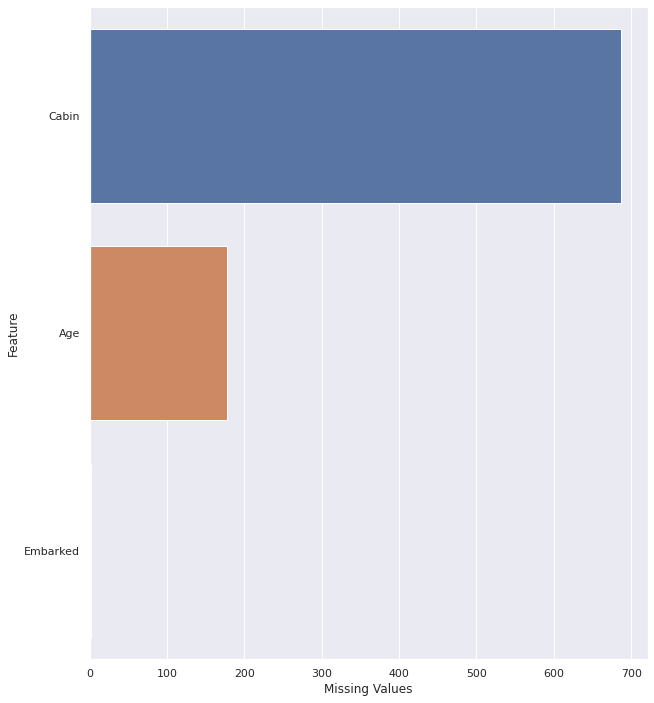

In [177]:
sns.set(rc={"figure.figsize":(10, 12)})
g=sns.barplot(data=missing_vals[missing_vals['Missing Values'] > 0].sort_values(by='Missing Values', ascending=False), 
              x = 'Missing Values', 
              y = 'Feature'
              );

In [178]:
df_train['Survived'].unique()

array([0, 1])

# EDA

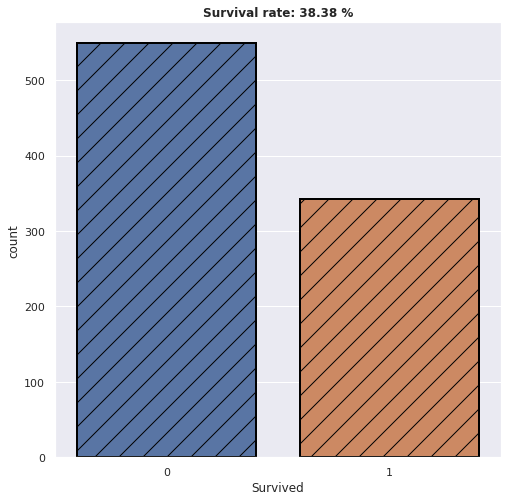

In [179]:
plt.figure(figsize=(8,8))
sns.color_palette("rocket", as_cmap=True)
ax = sns.countplot(data = df_train, x ='Survived',edgecolor="black", hatch='/',linewidth=2)
plt.title(f'Survival rate: {100*(1-ax.patches[0].get_height()/df_train.shape[0]):.2f} %',fontweight="bold")
plt.show()

In [180]:
def des_object(df, varname):
    table = vcounts = df_train[varname].value_counts()
    vcounts_len = len(vcounts)
    std = round(float(df_train[[varname,'Survived']].groupby(varname).agg(['mean']).std()),0)   
    print("")
    print("*********************************")

    plt.figure(figsize=(16,5))
    plt.subplot(121)
    plt.axis([0, 10, 0, 10])
    i = 7.5
    plt.text(0, 8.5, f"there is: {vcounts_len} different values", horizontalalignment='left', fontsize=12 )
    for row in range(np.min([len(table),10])):
      text = table.index[row] + ": " + str(table.iloc[row])      
      plt.text(0, i, text, horizontalalignment='left', fontsize=12 )
      i-=0.5
    plt.text(0, i-0.5, f"std: {std}", horizontalalignment='left', fontsize=12 )    
    plt.text(0, 9, '-------------------------------------------------------', horizontalalignment='left', fontsize=12 )
    plt.title(varname + "| type:" + str(df[varname].dtype),loc='left', weight = 'bold')
    plt.axis('off')  
    plt.subplot(122)
    g = sns.boxenplot(x = varname, y='Survived', data = df_train,showfliers = False)
    sns.pointplot(x = varname, y='Survived', data = df_train,linestyles='--', scale=0.4, 
              color='k', capsize=0)
    g.set_title('Mean price by category')
    plt.xlabel('')
    plt.xticks(rotation=90)      
    plt.tight_layout()
    plt.show()
    print("*********************************")
    print("")
    
def des_numeric(df, varname):
    print("*********************************")    
    table = pd.DataFrame(df[varname].describe().round(2))
    skw = skew(df[varname], axis=0, bias=True)
    kts = kurtosis(df[varname], axis=0, bias=True)    
    plt.figure(figsize=(16,5))
    plt.subplot(131)
    plt.axis([0, 10, 0, 10])
    i = 8.5
    for row in range(len(table)):
      text = table.index[row] + ": " + str(table.iloc[row,0])      
      plt.text(0, i, text, horizontalalignment='left', fontsize=12 )
      i-=0.5
    
    
    plt.text(0, 9, '-------------------------------------------------------', horizontalalignment='left', fontsize=12 )
    plt.text(0, i, f"NA values: {df[varname].isna().sum()}", horizontalalignment='left', fontsize=12 )
    plt.text(0, i-0.5, f"unique values: {df[varname].nunique()}", horizontalalignment='left', fontsize=12 )
    plt.text(0, i-1.5, f"skew: {round(skw,2)}", horizontalalignment='left', fontsize=12 )
    plt.text(0, i-2, f"kurtosis: {round(kts,2)}", horizontalalignment='left', fontsize=12 )

    plt.title(varname + "| type:" + str(df[varname].dtype),loc='left', weight = 'bold')
    plt.axis('off')

    plt.subplot(132)
    g= sns.histplot(data=df[varname], kde = True)
    g.set_title('Histogram')
    plt.subplot(133)
    g1 = sns.boxplot(data=df[varname], palette=['#7FFF00'])
    g1.set_title('Boxplot')
    plt.xticks([])
    plt.tight_layout()
    plt.show()
    
def des_df(df):
    for c in df.columns:
        if df[c].dtype == object:
            des_object(df,c)
        else:
            des_numeric(df,c)

* **PClass**

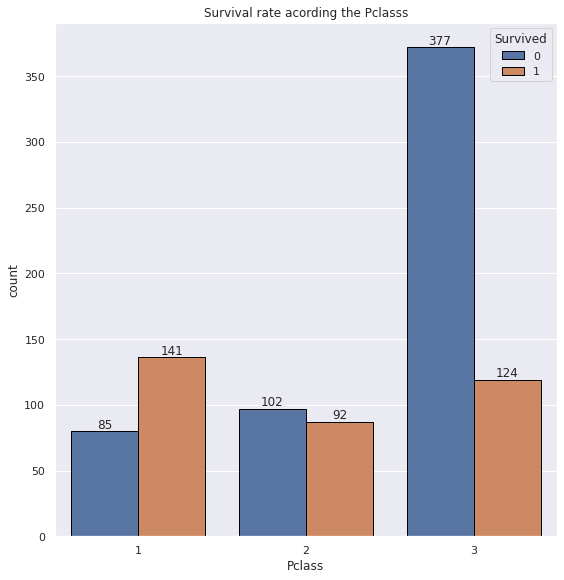

In [181]:
plt.figure(figsize=(8,8))
sns.color_palette("rocket", as_cmap=True)
ax = sns.countplot(data = df_train, x ='Pclass', hue = 'Survived', hue_order=[0,1],
                  edgecolor="black",linewidth=1)
for p in ax.patches:        
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()+5
    ax.annotate(y, (x, y), ha='center', va='center')
   
plt.tight_layout()
plt.title('Survival rate acording the Pclasss')
plt.show()

* **Sex**

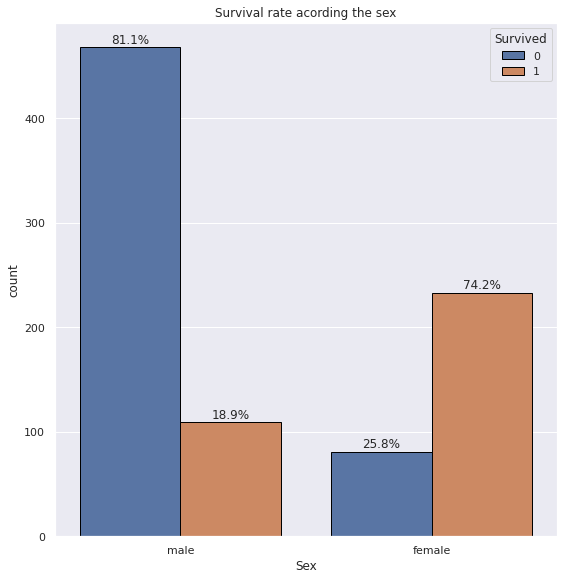

In [182]:
plt.figure(figsize=(8,8))
sns.color_palette("rocket", as_cmap=True)
ax = sns.countplot(data = df_train, x ='Sex', hue = 'Survived', hue_order=[0,1],
                  edgecolor="black",linewidth=1)

total_men = df_train['Sex'].value_counts()['male']
total_woman = df_train['Sex'].value_counts()['female']
totals = [total_men,total_woman,total_men,total_woman] 
i=0
for p in ax.patches:    
    percentage = f'{100 * p.get_height() / totals[i]:.1f}%\n'
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.annotate(percentage, (x, y), ha='center', va='center')
    i+=1
plt.tight_layout()
plt.title('Survival rate acording the sex')
plt.show()

In [183]:
df_all = pd.concat([df_train,df_test])

In [184]:
df_all.isna().sum()

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             263
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1014
Embarked          2
dtype: int64

* **Title**

In [186]:
df_all.loc[:,'title'] =  df_all["Name"].apply(lambda name: (name.split(',')[1].split('.')[0]).strip())
df_all.loc[:,'title'] =df_all['title'].apply(lambda x: x if ['Master','Miss','Mr','Mrs'].count(x) > 0 else 'other')

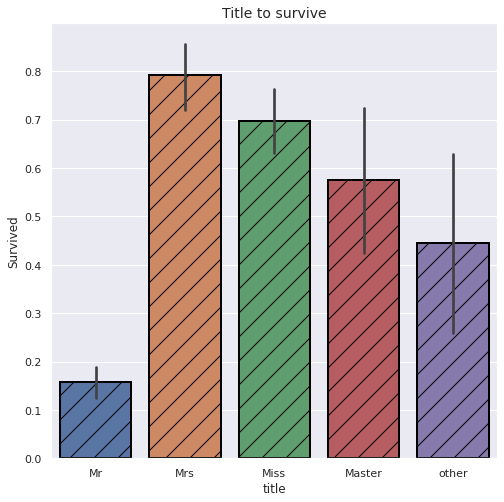

In [187]:
plt.figure(figsize=(8,8))
sns.barplot(x="title", y="Survived", data=df_all,edgecolor="black", hatch='/',linewidth=2)
plt.title('Title to survive', fontsize=14)
plt.show()

* **Age**

*********************************


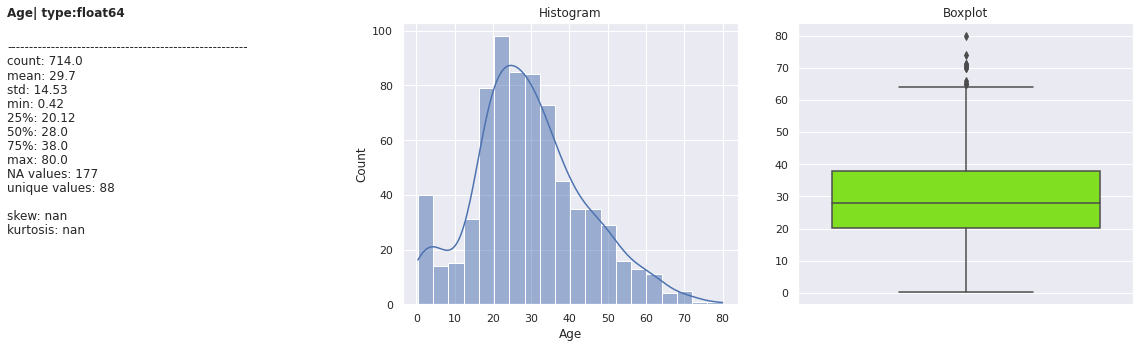

In [185]:
des_df(df_train[['Age']])

In [188]:
group = df_all.groupby(['title','Pclass']).agg('mean')['Age']
group

title   Pclass
Master  1          6.984000
        2          2.757273
        3          6.090000
Miss    1         30.338983
        2         20.717083
        3         17.360874
Mr      1         41.450758
        2         32.346715
        3         28.318910
Mrs     1         43.208955
        2         33.518519
        3         32.326531
other   1         44.285714
        2         39.545455
        3               NaN
Name: Age, dtype: float64

In [189]:
df_all['Age'] = df_all.apply(lambda x: x['Age'] if x['Age']>0 else group[x['title']][x['Pclass']],axis=1)
df_all['Age'] = df_all['Age'].fillna(39)

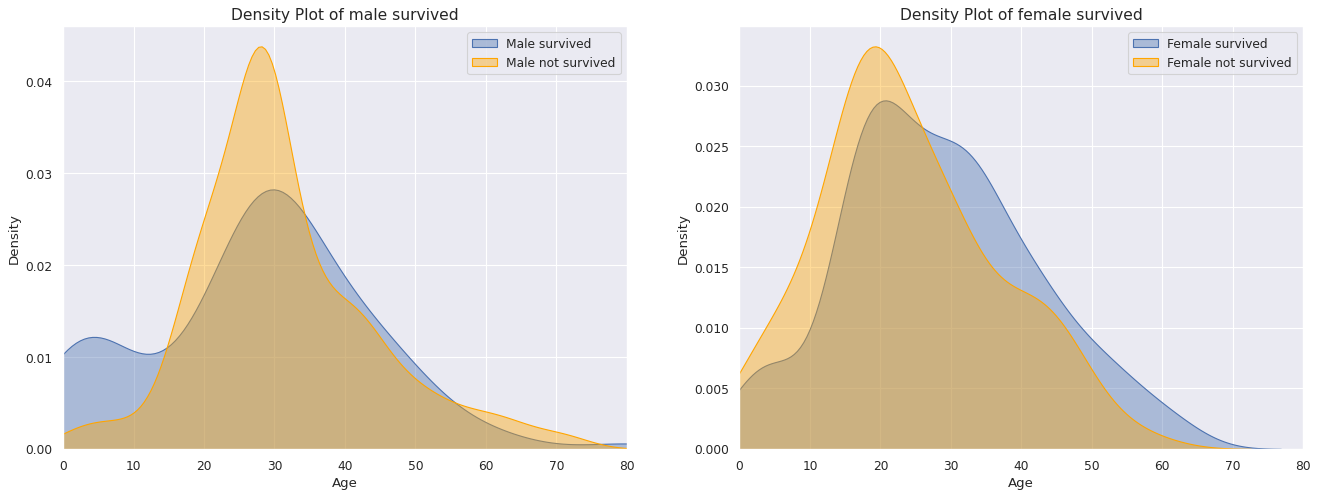

In [190]:
# Draw Plot
plt.figure(figsize=(20,7), dpi= 80)
plt.subplot(121)
a=sns.kdeplot(df_all.loc[(df_all['Survived'] == 1) & (df_all['Sex'] == 'male'), "Age"], shade=True, color="b", label="Male survived", alpha=.4)
sns.kdeplot(df_all.loc[(df_all['Survived'] == 0) & (df_all['Sex'] == 'male'), "Age"], shade=True, color="orange", label="Male not survived", alpha=.4)
a.set(xlim=(0, df_train["Age"].max()))
plt.title('Density Plot of male survived', fontsize=14)
plt.legend()

plt.subplot(122)
a=sns.kdeplot(df_all.loc[(df_all['Survived'] == 1) & (df_all['Sex'] == 'female'), "Age"], shade=True, color="b", label="Female survived", alpha=.4)
sns.kdeplot(df_all.loc[(df_all['Survived'] == 0) & (df_all['Sex'] == 'female'), "Age"], shade=True, color="orange", label="Female not survived", alpha=.4)
a.set(xlim=(0, df_train["Age"].max()))
plt.title('Density Plot of female survived', fontsize=14)
plt.legend()

plt.show()

# Features engineering

In [191]:
bins = [-1,5,13, 31, 60, 80]
labels = ['Baby','Child', 'Young Adult', 'Adult', 'Senior']
df_all['AgeBin'] = pd.cut(df_all["Age"], bins, labels = labels).astype('object')

In [192]:
df_all['AgeBin'].value_counts()

Young Adult    721
Adult          448
Baby            56
Child           51
Senior          33
Name: AgeBin, dtype: int64

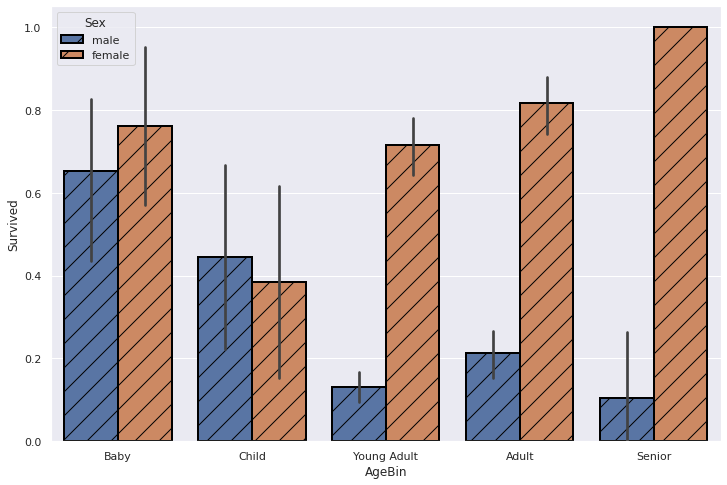

In [193]:
plt.figure(figsize=(12,8))
sns.barplot(x="AgeBin", y="Survived", data=df_all,hue='Sex', order=['Baby','Child', 'Young Adult', 'Adult', 'Senior'],edgecolor="black", hatch='/',linewidth=2)
plt.show()

In [194]:
df_all.loc[:,'Sex'] = (df_all['Sex'] == 'male').astype(int)

In [195]:
df_all.loc[:,'Family_size'] = df_all['SibSp'] + df_all['Parch']
df_all.loc[:,'alone'] = df_all['Ticket'].apply(lambda t: 0 if list(df_all['Ticket']).count(t)>1 else 1)

In [196]:
df_all['Embarked'].fillna(df_all['Embarked'].mode()[0], inplace = True)

In [197]:
df_all['Fare'].fillna(df_all['Fare'].mean(), inplace = True)

In [198]:
ticket_counts = df_all['Ticket'].value_counts()
def get_fare(ticket_no):
    fare = df_all[df_all['Ticket']==ticket_no]['Fare'].max()
    return round(fare/ticket_counts[ticket_no],2)

In [199]:
df_all.loc[:,'fare_to_1'] = df_all['Ticket'].apply(lambda x: get_fare(x))

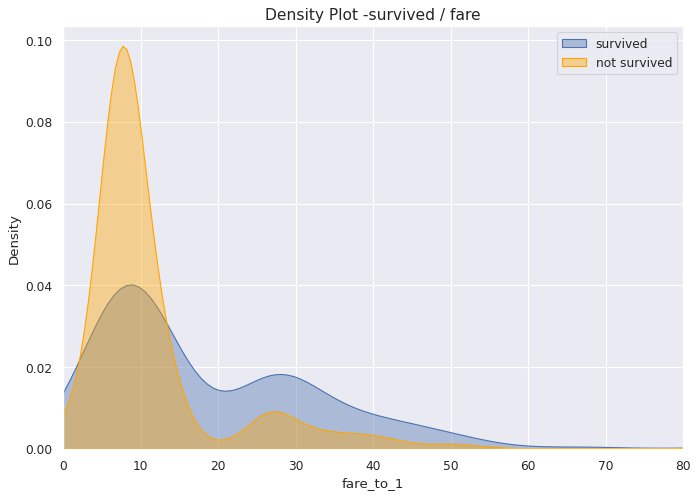

In [200]:
plt.figure(figsize=(10,7), dpi= 80)
a=sns.kdeplot(df_all.loc[(df_all['Survived'] == 1), "fare_to_1"], shade=True, color="b", label="survived", alpha=.4)
sns.kdeplot(df_all.loc[(df_all['Survived'] == 0), "fare_to_1"], shade=True, color="orange", label="not survived", alpha=.4)
a.set(xlim=(0, df_train["Age"].max()))
plt.title('Density Plot -survived / fare', fontsize=14)
plt.legend()

plt.legend()

plt.show()

In [201]:
col_to_dum = ['Embarked']
df_dummies = pd.get_dummies(df_all[col_to_dum])
df_all = pd.concat([df_all, df_dummies], axis=1)

In [202]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 20 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   int64  
 5   Age          1309 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1309 non-null   float64
 10  Cabin        295 non-null    object 
 11  Embarked     1309 non-null   object 
 12  title        1309 non-null   object 
 13  AgeBin       1309 non-null   object 
 14  Family_size  1309 non-null   int64  
 15  alone        1309 non-null   int64  
 16  fare_to_1    1309 non-null   float64
 17  Embarked_C   1309 non-null   uint8  
 18  Embarked_Q   1309 non-null   uint8  
 19  Embarke

In [203]:
df_all['Cabin'].unique()

array([nan, 'C85', 'C123', 'E46', 'G6', 'C103', 'D56', 'A6',
       'C23 C25 C27', 'B78', 'D33', 'B30', 'C52', 'B28', 'C83', 'F33',
       'F G73', 'E31', 'A5', 'D10 D12', 'D26', 'C110', 'B58 B60', 'E101',
       'F E69', 'D47', 'B86', 'F2', 'C2', 'E33', 'B19', 'A7', 'C49', 'F4',
       'A32', 'B4', 'B80', 'A31', 'D36', 'D15', 'C93', 'C78', 'D35',
       'C87', 'B77', 'E67', 'B94', 'C125', 'C99', 'C118', 'D7', 'A19',
       'B49', 'D', 'C22 C26', 'C106', 'C65', 'E36', 'C54',
       'B57 B59 B63 B66', 'C7', 'E34', 'C32', 'B18', 'C124', 'C91', 'E40',
       'T', 'C128', 'D37', 'B35', 'E50', 'C82', 'B96 B98', 'E10', 'E44',
       'A34', 'C104', 'C111', 'C92', 'E38', 'D21', 'E12', 'E63', 'A14',
       'B37', 'C30', 'D20', 'B79', 'E25', 'D46', 'B73', 'C95', 'B38',
       'B39', 'B22', 'C86', 'C70', 'A16', 'C101', 'C68', 'A10', 'E68',
       'B41', 'A20', 'D19', 'D50', 'D9', 'A23', 'B50', 'A26', 'D48',
       'E58', 'C126', 'B71', 'B51 B53 B55', 'D49', 'B5', 'B20', 'F G63',
       'C62 C64',

In [204]:
df_all['Deck'] = df_all.Cabin.str.extract('([a-zA-Z]+)', expand=False)
df_all['Deck'].isna().sum()

1014

In [205]:
def get_deck(ticket_no): 

    cabin_list =  list(df_all[(df_all['Ticket']==ticket_no) & (df_all['Deck'].notna())]['Deck'])
    if len(cabin_list) > 0:        
        return cabin_list[0]
    else:
        return np.nan

In [206]:
df_all['Deck']=df_all['Ticket'].apply(lambda x: get_deck(x))
df_all['Deck'].isna().sum()

998

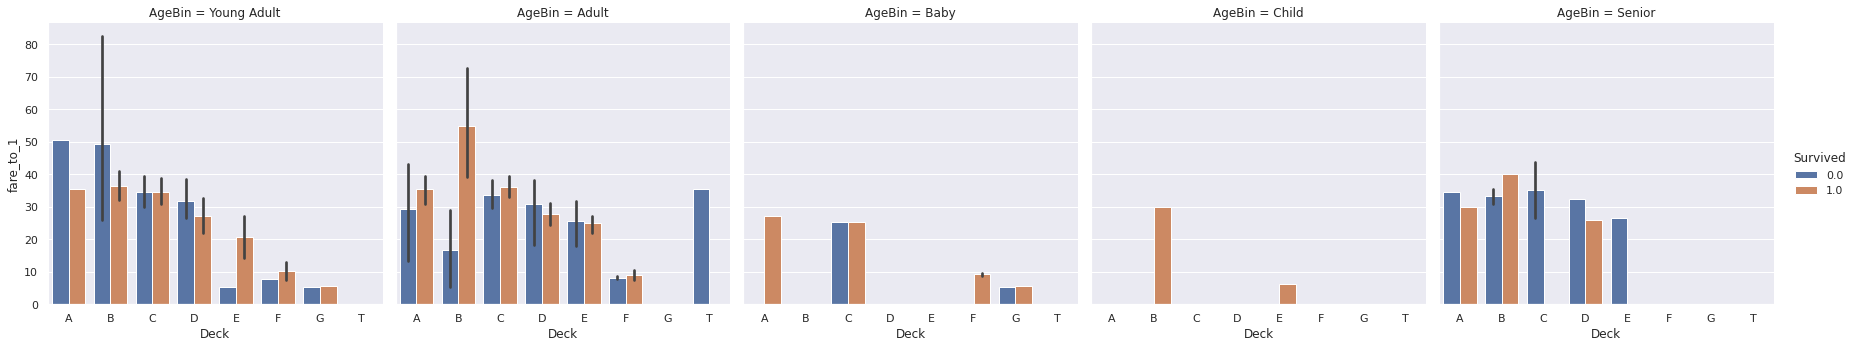

In [207]:
sns.catplot(data=df_all, x='Deck', y='fare_to_1', order=['A','B','C','D','E','F','G','T'], hue='Survived',col='AgeBin', kind='bar')
plt.show()

In [208]:
df_all.loc[:,'DefinedDeck'] = df_all['Deck'].notna().astype(int)
df_all['Deck']=df_all['Deck'].fillna('unknown')

In [209]:
df_all.isna().sum()

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age               0
SibSp             0
Parch             0
Ticket            0
Fare              0
Cabin          1014
Embarked          0
title             0
AgeBin            0
Family_size       0
alone             0
fare_to_1         0
Embarked_C        0
Embarked_Q        0
Embarked_S        0
Deck              0
DefinedDeck       0
dtype: int64

In [210]:
df_final=df_all.drop(['PassengerId','Name','SibSp','Parch','Ticket','Fare','Cabin','title','Age','Embarked' ],axis=1)

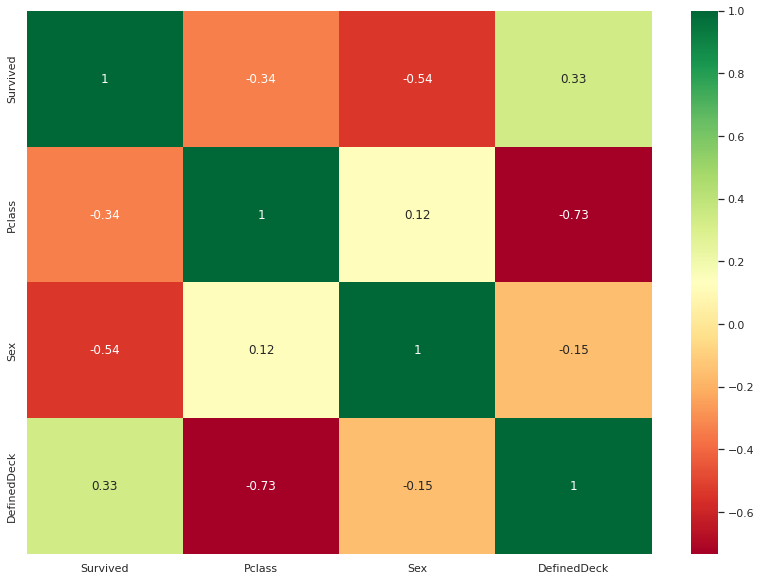

In [211]:
corrmat = df_final.corr()
top_corr_features = corrmat.index[abs(corrmat["Survived"])>0.3]
plt.figure(figsize=(14,10))
g = sns.heatmap(df_final[top_corr_features].corr(),annot=True,cmap="RdYlGn")

In [212]:
df_final

,Survived,Pclass,Sex,AgeBin,Family_size,alone,fare_to_1,Embarked_C,Embarked_Q,Embarked_S,Deck,DefinedDeck
0,0.0,3,1,Young Adult,1,1,7.25,0,0,1,unknown,0
1,1.0,1,0,Adult,1,0,35.64,1,0,0,C,1
2,1.0,3,0,Young Adult,0,1,7.92,0,0,1,unknown,0
3,1.0,1,0,Adult,1,0,26.55,0,0,1,C,1
4,0.0,3,1,Adult,0,1,8.05,0,0,1,unknown,0
...,...,...,...,...,...,...,...,...,...,...,...,...
413,NaN,3,1,Young Adult,0,1,8.05,0,0,1,unknown,0
414,NaN,1,0,Adult,0,0,36.30,1,0,0,C,1
415,NaN,3,1,Adult,0,1,7.25,0,0,1,unknown,0
416,NaN,3,1,Young Adult,0,1,8.05,0,0,1,unknown,0


In [213]:
oe = OrdinalEncoder(categories=[['Baby','Child', 'Young Adult', 'Adult', 'Senior']])
df_final.loc[:, 'AgeBin'] = oe.fit_transform(df_final[['AgeBin']])
oe = OrdinalEncoder(categories=[['A','B','C','D','E','F','G','T','unknown']])
df_final.loc[:, 'Deck'] = oe.fit_transform(df_final[['Deck']])

In [214]:
df_final.loc[:, ['Pclass','fare_to_1']]= boxcox1p(df_final.loc[:, ['Pclass','fare_to_1']],0.15)

# Model

In [216]:
df_test_final = df_final[df_final['Survived'].isna()].copy().drop('Survived',axis=1)
df_train_final = df_final[df_final['Survived'].notna()].copy()

In [217]:
X=df_train_final.loc[:, ~df_train_final.columns.isin(['Survived'])]
y=df_train_final['Survived']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0)

In [218]:
X_train

,Pclass,Sex,AgeBin,Family_size,alone,fare_to_1,Embarked_C,Embarked_Q,Embarked_S,Deck,DefinedDeck
105,1.540963,1,2.0,0,1,2.587072,0,0,1,8.0,0
68,1.540963,0,2.0,6,1,2.590189,0,0,1,8.0,0
253,1.540963,1,2.0,1,0,2.610301,0,0,1,8.0,0
320,1.540963,1,2.0,0,1,2.482401,0,0,1,8.0,0
706,1.194318,0,3.0,0,1,3.289999,0,0,1,8.0,0
...,...,...,...,...,...,...,...,...,...,...,...
835,0.730463,0,3.0,2,0,4.364880,1,0,0,4.0,1
192,1.540963,0,2.0,1,1,2.579255,0,0,1,8.0,0
629,1.540963,1,2.0,0,1,2.560341,0,1,0,8.0,0
559,1.540963,0,3.0,1,0,2.707324,0,0,1,8.0,0


**Logisitc regression**

In [219]:
logreg=LogisticRegression(multi_class='ovr', max_iter=50000)
logreg.fit(X_train,y_train)
predictions = logreg.predict(X_test)
acc = accuracy_score(y_test, predictions) 
f1 = f1_score(y_test, predictions,average='micro')
print(f1, acc)

0.8026905829596412 0.8026905829596412


**Features importance**

In [220]:
result = permutation_importance(logreg, X_train, y_train, n_repeats=10,random_state=0)
imp = result.importances_mean

In [221]:
res_dict = {X.columns[index]: imp[index] for index,column in enumerate(X.columns)}
df_res = pd.DataFrame({'Variable':list(res_dict.keys()), 'importance': list(res_dict.values())}).sort_values('importance', ascending =False)
df_res = df_res.set_index('Variable')

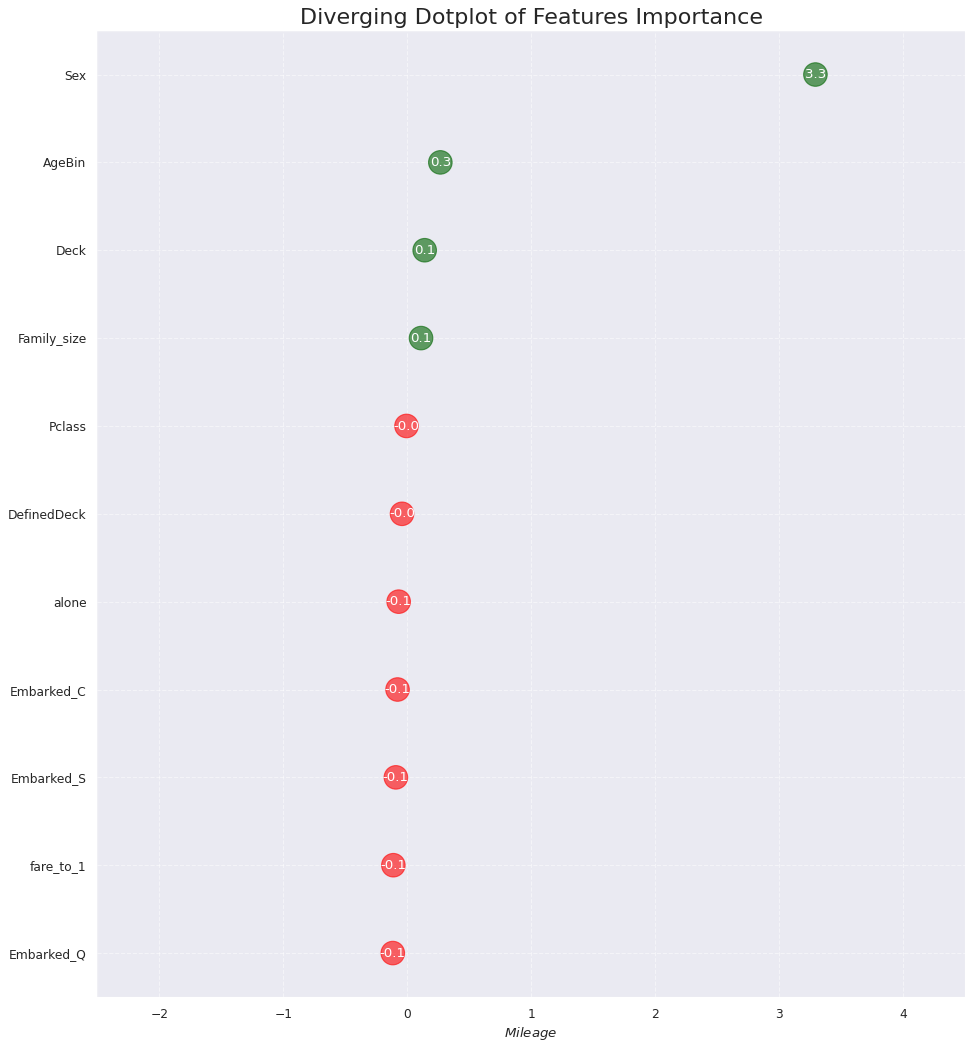

In [222]:
x = df_res.loc[:, ['importance']]
df_res['importance_z'] = ((x - x.mean())/x.std())+0.3
df_res['colors'] = ['red' if x < 0 else 'darkgreen' for x in df_res['importance_z']]
df_res.sort_values('importance_z', inplace=True)
df_res.reset_index(inplace=True)

# Draw plot
plt.figure(figsize=(14,16), dpi= 80)
plt.scatter(df_res.importance_z, df_res.index, s=450, alpha=.6, color=df_res.colors)
for x1, y1, tex in zip(df_res.importance_z, df_res.index, df_res.importance_z):
    t = plt.text(x1, y1, round(tex, 1), horizontalalignment='center', 
                 verticalalignment='center', fontdict={'color':'white'})

# Decorations
# Lighten borders
plt.gca().spines["top"].set_alpha(.3)
plt.gca().spines["bottom"].set_alpha(.3)
plt.gca().spines["right"].set_alpha(.3)
plt.gca().spines["left"].set_alpha(.3)

plt.yticks(df_res.index, df_res.Variable)
plt.title('Diverging Dotplot of Features Importance', fontdict={'size':20})
plt.xlabel('$Mileage$')
plt.grid(linestyle='--', alpha=0.5)
plt.xlim(-2.5, 4.5)
plt.show()

# Neural networks

* **Sklearn MLP Cassifier**

In [225]:
class_neur = MLPClassifier(random_state=1, max_iter=500)

In [226]:
params = {
    'activation': ['relu', 'tanh', 'logistic'],  
    'alpha': np.linspace(0.1, 10, 5),
    'hidden_layer_sizes': [
        (20,10),(16,8),(10,5)  
    ],
    'batch_size': [8,16,32]
}

In [227]:
clas = GridSearchCV(estimator=class_neur, param_grid=params,
                   n_jobs=8, cv=3, refit=True, verbose=5)  # <-- verbose=5
clas.fit(X_train, y_train)



Fitting 3 folds for each of 135 candidates, totalling 405 fits


GridSearchCV(cv=3, estimator=MLPClassifier(max_iter=500, random_state=1),
             n_jobs=8,
             param_grid={'activation': ['relu', 'tanh', 'logistic'],
                         'alpha': array([ 0.1  ,  2.575,  5.05 ,  7.525, 10.   ]),
                         'batch_size': [8, 16, 32],
                         'hidden_layer_sizes': [(20, 10), (16, 8), (10, 5)]},
             verbose=5)

In [228]:
print(clas.best_estimator_)
print(clas.best_score_)

MLPClassifier(alpha=0.1, batch_size=8, hidden_layer_sizes=(10, 5), max_iter=500,
              random_state=1)
0.8218801761402658


* **Keras**

In [229]:
model = Sequential()
model.add(layers.Dense(20, activation='relu', input_dim=X_train.shape[1]))
model.add(Dropout(0.4))
model.add(layers.Dense(10, activation='tanh'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])                                                                     

In [230]:
history =model.fit(X_train, y_train, epochs=500, batch_size=32, verbose=2)

Epoch 1/500
21/21 - 1s - loss: 0.9020 - accuracy: 0.4626
Epoch 2/500
21/21 - 0s - loss: 0.7447 - accuracy: 0.5105
Epoch 3/500
21/21 - 0s - loss: 0.6856 - accuracy: 0.6033
Epoch 4/500
21/21 - 0s - loss: 0.6924 - accuracy: 0.5928
Epoch 5/500
21/21 - 0s - loss: 0.6464 - accuracy: 0.6437
Epoch 6/500
21/21 - 0s - loss: 0.6479 - accuracy: 0.6542
Epoch 7/500
21/21 - 0s - loss: 0.6640 - accuracy: 0.6302
Epoch 8/500
21/21 - 0s - loss: 0.6435 - accuracy: 0.6422
Epoch 9/500
21/21 - 0s - loss: 0.6301 - accuracy: 0.6467
Epoch 10/500
21/21 - 0s - loss: 0.6293 - accuracy: 0.6647
Epoch 11/500
21/21 - 0s - loss: 0.6342 - accuracy: 0.6422
Epoch 12/500
21/21 - 0s - loss: 0.6295 - accuracy: 0.6482
Epoch 13/500
21/21 - 0s - loss: 0.6266 - accuracy: 0.6617
Epoch 14/500
21/21 - 0s - loss: 0.6087 - accuracy: 0.6677
Epoch 15/500
21/21 - 0s - loss: 0.5996 - accuracy: 0.6946
Epoch 16/500
21/21 - 0s - loss: 0.5887 - accuracy: 0.6916
Epoch 17/500
21/21 - 0s - loss: 0.5934 - accuracy: 0.6751
Epoch 18/500
21/21 - 0s

In [231]:
test_loss, test_acc = model.evaluate(X_test, y_test)

7/7 [==============================] - 0s 2ms/step - loss: 0.4267 - accuracy: 0.7982


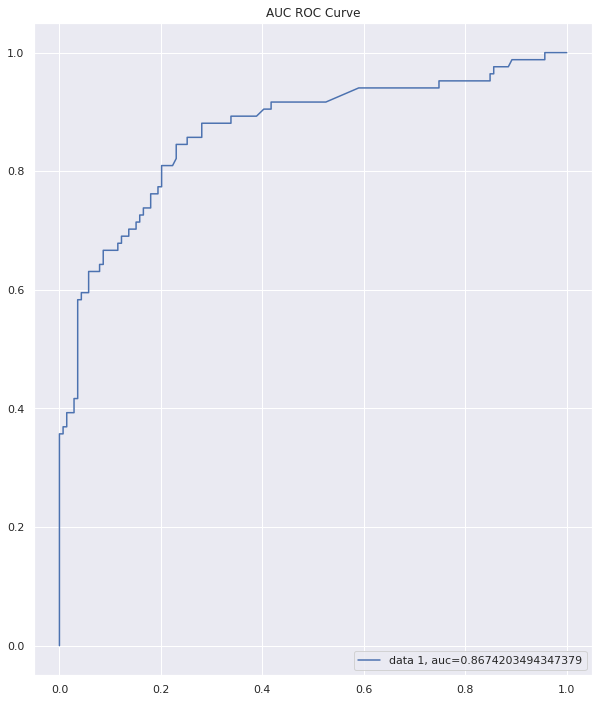

In [232]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

y_pred_proba =model.predict(X_test)
fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.title("AUC ROC Curve")
plt.show()

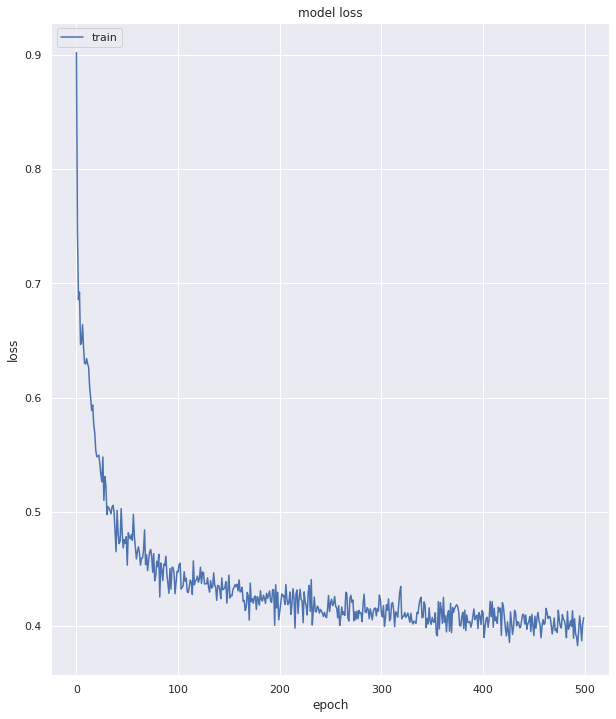

In [233]:
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Submission

In [234]:
pred = (model.predict(df_test_final) > 0.5)*1 
pred = pred.reshape(418,)
pred.shape

(418,)

In [235]:
target = pd.Series(pred, name='Survived')

output = pd.concat({'PassengerId':test_id, 'Survived':target}
                   ,axis='columns')

output.to_csv('submission.csv', index=False, header=True)

[CV 1/3] END activation=relu, alpha=0.1, batch_size=8, hidden_layer_sizes=(10, 5);, score=0.812 total time=  13.0s
[CV 1/3] END activation=relu, alpha=0.1, batch_size=16, hidden_layer_sizes=(10, 5);, score=0.807 total time=   4.7s
[CV 3/3] END activation=relu, alpha=0.1, batch_size=32, hidden_layer_sizes=(16, 8);, score=0.838 total time=   4.1s
[CV 2/3] END activation=relu, alpha=0.1, batch_size=32, hidden_layer_sizes=(10, 5);, score=0.816 total time=   4.0s
[CV 1/3] END activation=relu, alpha=2.575, batch_size=8, hidden_layer_sizes=(10, 5);, score=0.614 total time=   7.3s
[CV 1/3] END activation=relu, alpha=2.575, batch_size=16, hidden_layer_sizes=(10, 5);, score=0.623 total time=   3.8s
[CV 3/3] END activation=relu, alpha=2.575, batch_size=32, hidden_layer_sizes=(20, 10);, score=0.671 total time=   3.8s
[CV 3/3] END activation=relu, alpha=2.575, batch_size=32, hidden_layer_sizes=(10, 5);, score=0.671 total time=   4.2s
[CV 2/3] END activation=relu, alpha=5.05, batch_size=8, hidden_la